# 2018/2019 - Task List 1

1. Generate random variable from prefered dystribution using Pyro (pyro.sample)
    
    - animate how distribution of values changes
    - animate histograms of values
    - start with empty list of values, generate new samples, generate histogram
    
    
2. Write a simulator (and exact solution utilizing Bayes theorem) for chances to be ill on a certain disease. We know that it affects from about 1 to 100 out of 50,000 people. There was developed a test to check whether the person has the disease and it is quite accurate: the probability that the test result is positive (suggesting the person has the disease), given that the person does not have the disease, is only 2 percent; the probability that the test result is negative (suggesting the person does not have the disease), given that the person has the disease, is only 1 percent. When a random person gets tested for the disease and the result comes back positive, what is the probability that the person has the disease? Check whole parameter space and visualise results.

    - it must be a simulator!
    - sample from distribution using given probabilities
    - repeate experiment and compare with Bayes equation


## Required imports

In [119]:
# %matplotlib inline
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import enum

from matplotlib import animation, rc
from IPython.display import HTML

## Generating single value from normal distribution with given mean and variance

In [12]:
mean = 0
variance = 10
x = pyro.sample("normal_sampling", pyro.distributions.Normal(mean, variance))
print(x)

tensor(10.0844)


## Sampling from categorical probabilities with given probabilities

In [21]:
x = pyro.sample("categorical_sampling", pyro.distributions.Categorical(logits = torch.tensor([0.5, 0.5])))
print(x)

tensor(1)


## Animating data

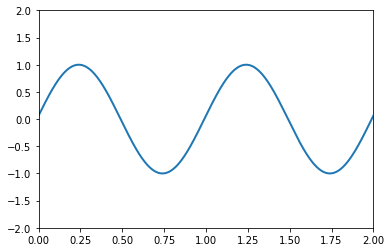

In [19]:
def animate():
    # First set up the figure, the axis, and the plot element we want to animate
    fig, ax = plt.subplots()

    ax.set_xlim(( 0, 2))
    ax.set_ylim((-2, 2))

    line, = ax.plot([], [], lw=2)
    
    # animation function. This is called sequentially
    def sin(i):
        x = np.linspace(0, 2, 1000)
        y = np.sin(2 * np.pi * (x - 0.01 * i))
        line.set_data(x, y)
        return (line,)

    # initialization function: plot the background of each frame
    def init():
        line.set_data([], [])
        return (line,)
    # call the animator. blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, sin, init_func=init,
                                   frames=100, interval=20, blit=True)
    return HTML(anim.to_jshtml())

animate()

## Drawing histogram

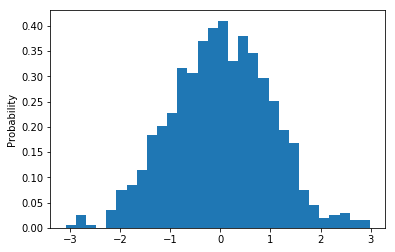

In [22]:
x = np.random.normal(size = 1000)
plt.hist(x, density=True, bins=30)
plt.ylabel('Probability');

## Task 1

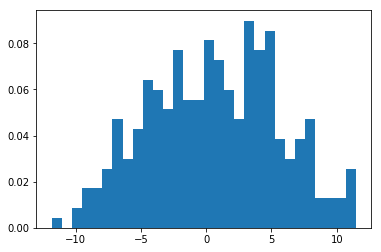

In [102]:
def animate(append):
    fig, ax = plt.subplots()
    values = []
    
    def update(frame):
        ax.clear()
        append(values)
        ax.hist(values, density=True, bins=30)

    anim = animation.FuncAnimation(fig, update, frames=300, interval=20)
    return HTML(anim.to_jshtml())

animate(lambda values: values.append(pyro.sample("normal_sampling", pyro.distributions.Normal(0, 5))))

## Task 2

In [126]:
class HealthState(enum.Enum):
    healthy = 0
    sick = 1


class TestResult(enum.Enum):
    negative = 0
    positive = 1


def not_p(p):
    return 1 - p

class Simulator:
    def __init__(self,
                 population_size,
                 num_of_sick = 0,
                 p_false_positive = 0,
                 p_false_negative = 0):
        self.population_size = population_size
        self.num_of_sick = num_of_sick
        self.p_false_positive = p_false_positive
        self.p_false_negative = p_false_negative
        self.population = None

    def run(self):
        self.population = self.test(self.init_population())

    def init_population(self):
        population = np.zeros(self.population_size)
        for person_index in range(self.num_of_sick):
            population[person_index] = HealthState.sick.value
        return population.reshape(-1, 1)

    def test(self, population):
        def bernoulli(p):
            return torch.distributions.Bernoulli(p).sample()

        test_results = [
            [bernoulli(self.p_false_positive if HealthState.healthy.value == health_state else not_p(self.p_false_negative))]
            for health_state in population]
        return np.concatenate((population, test_results), axis=-1)

    def calculate_current_true_positive(self):
        def is_true_positive(person):
            return np.count_nonzero(person == 1) == len(person)

        num_of_true_positive = 0
        num_of_positive = 0
        for person in self.population:
            num_of_positive += person[TestResult.positive.value]
            num_of_true_positive += is_true_positive(person)
        return num_of_true_positive / num_of_positive

    def calculate_bayes_true_positive(self):
        p_sick = self.num_of_sick / self.population_size
        p_sick_intersection = not_p(self.p_false_negative) * p_sick
        return p_sick_intersection / (p_sick_intersection + self.p_false_positive * not_p(p_sick))


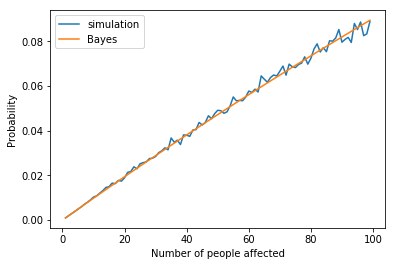

In [127]:
x = []
y_simulation = []
y_bayes = []

nums_of_sick = range(1, 100)
simulator = Simulator(population_size=50000,
                      p_false_positive=0.02,
                      p_false_negative=0.01)

for num_of_sick in nums_of_sick:
    simulator.num_of_sick = num_of_sick
    simulator.run()
    
    x.append(num_of_sick)
    y_simulation.append(simulator.calculate_current_true_positive())
    y_bayes.append(simulator.calculate_bayes_true_positive())
    
fig, ax = plt.subplots()
ax.plot(x, y_simulation, label='simulation')
ax.plot(x, y_bayes, label='Bayes')
plt.ylabel('Probability');
plt.xlabel('Number of people affected');
ax.legend(loc=2)